In [26]:
!conda install -y keras

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::keras==2.3.1=py36_0
  - defaults/noarch::boto3==1.9.162=py_0
  - defaults/linux-64::s3transfer==0.2.1=py36_0
  - defaults/linux-64::spyder==4.1.4=py36_0
  - defaults/noarch::botocore==1.12.189=py_0
  - defaults/linux-64::_anaconda_depends==2020.07=py36_0
  - defaults/linux-64::anaconda==custom=py36_1
  - defaults/noarch::numpydoc==1.1.0=py_0
  - conda-forge/noarch::sphinx==3.0.4=py_0
  - conda-forge/linux-64::tensorflow==1.14.0=hc3e5e64_0
  - defaults/noarch::s3fs==0.4.2=py_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/l

In [33]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 100)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

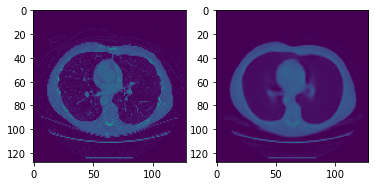

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

def normalize(array):

    normalized = (array - np.amin(array)) / (np.amax(array) - np.amin(array))

    return normalized

false_path = 'Double_Results/0007.npy'
false_array = normalize(np.load(false_path))

true_array = pd.y_train[6]

f = plt.figure()

f.add_subplot(1, 2, 1)
plt.imshow(true_array[64], vmin = 0, vmax = 1)

f.add_subplot(1, 2, 2)
plt.imshow(false_array[64], vmin = 0, vmax = 1)

plt.show()

In [37]:
print(np.amax(true_array))
print(np.amin(true_array))
print(np.amax(false_array))
print(np.amin(false_array))


1.0
0.0
1.0
0.0


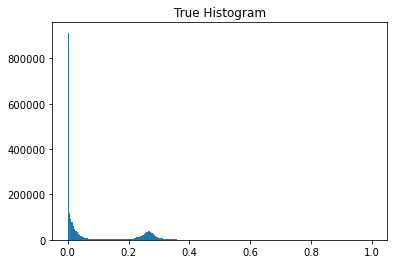

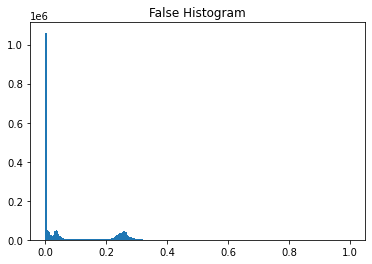

In [46]:
plt.hist(np.ravel(true_array), bins = 240)
plt.title('True Histogram')
plt.show()

plt.hist(np.ravel(false_array), bins = 240)
plt.title('False Histogram')
plt.show()

In [47]:
import cv2 as cv
import numpy.ma as ma

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.05, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices


mask_false = ma.masked_not_equal(extract_lung_mask(false_array, size = 128), 1)
mask_true = ma.masked_not_equal(extract_lung_mask(true_array, size = 128), 1)

In [48]:


def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    return tp, fp, fn

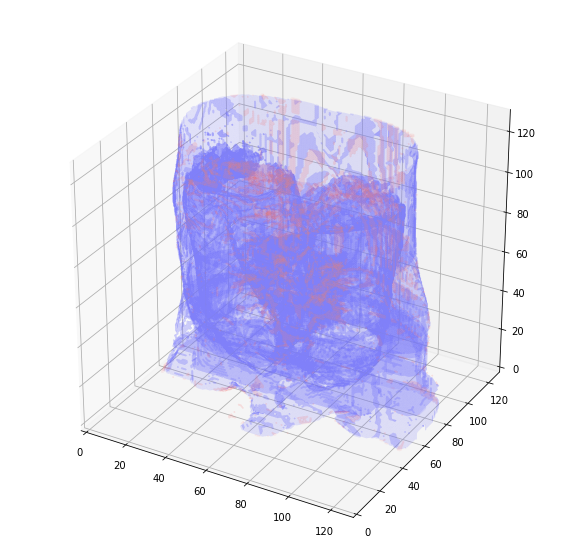

In [53]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
from skimage import measure

def plot_tpfp(tp, fp, fn):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')
    face_color_tp = [0.5, 0.5, 1]
    face_color_fp = [0.5, 0.5, 1]
    face_color_fn = [1, 0.5, 0.5]
    
    lis = [tp, fp, fn]
    face_color_lis = [face_color_tp, face_color_fp, face_color_fn]
    alphas = [0.2, 0.2, 0.1]
    
    for i in range(len(lis)):
        
        image = lis[i]
        p = image.transpose(2, 1, 0)
        verts, faces, normals, values = measure.marching_cubes_lewiner(p)
        mesh = Poly3DCollection(verts[faces], alpha = alphas[i])
        mesh.set_facecolor(face_color_lis[i])
        ax.add_collection3d(mesh)
        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])
    
    plt.show()
    
tp, fp, fn = tpfp(true_array, false_array)
plot_tpfp(tp, fp, fn)

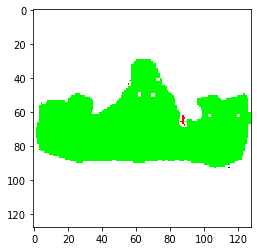

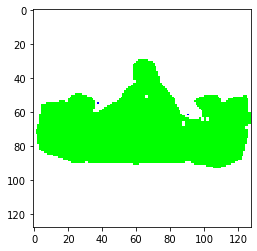

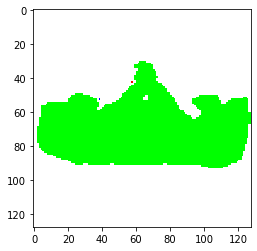

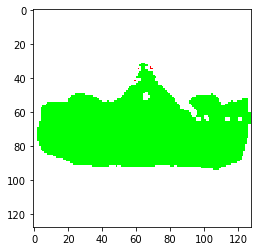

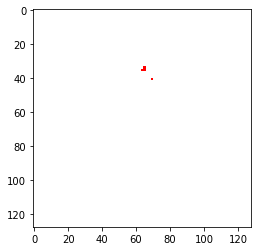

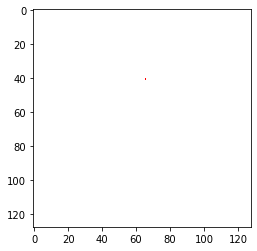

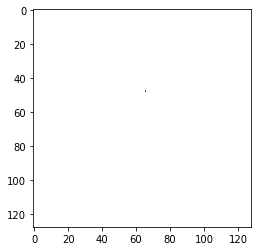

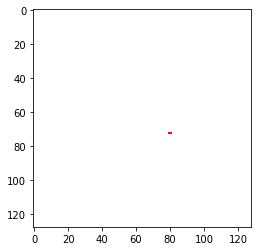

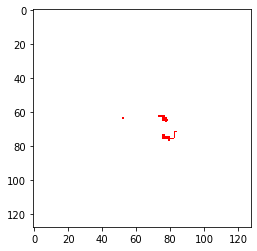

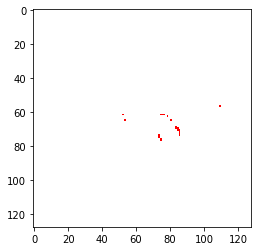

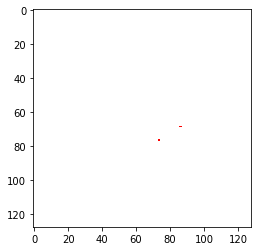

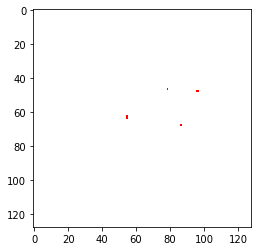

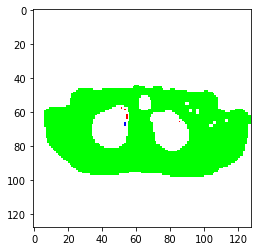

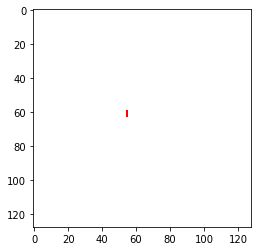

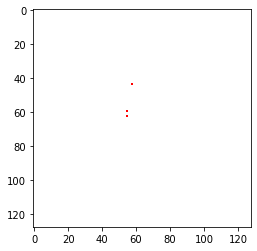

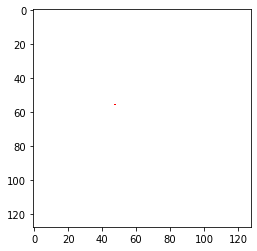

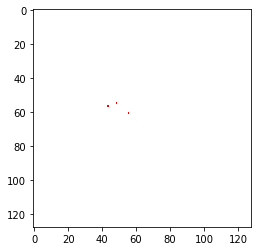

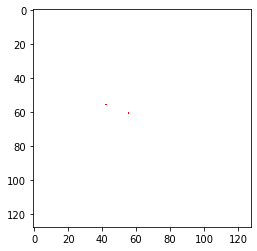

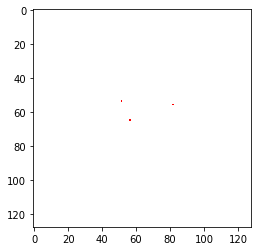

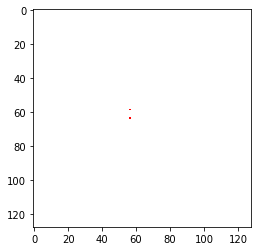

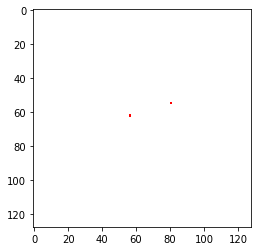

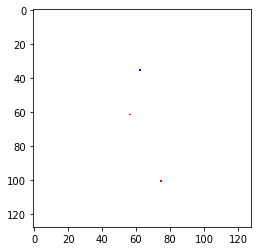

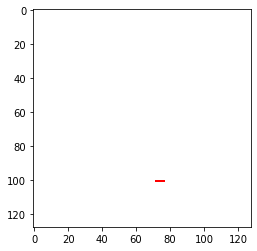

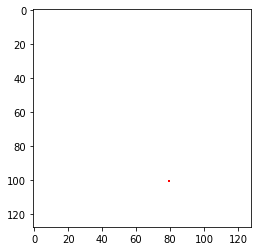

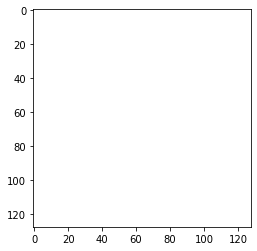

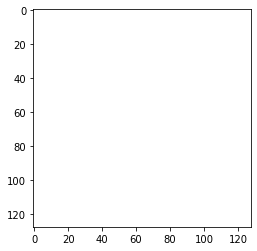

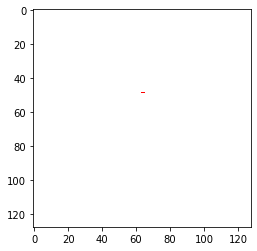

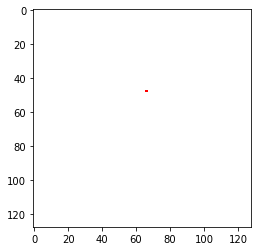

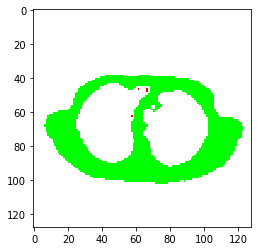

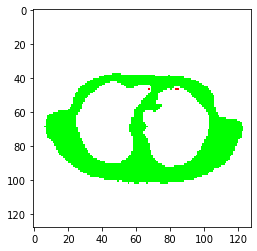

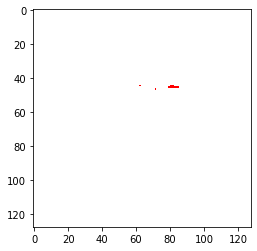

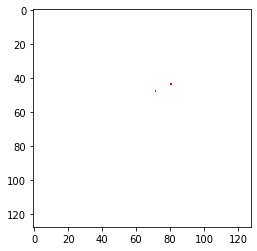

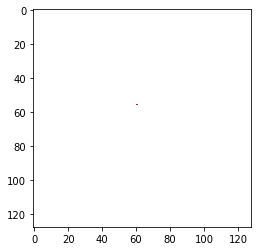

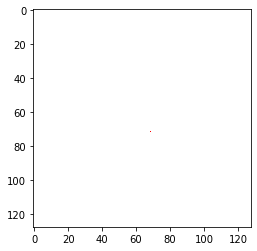

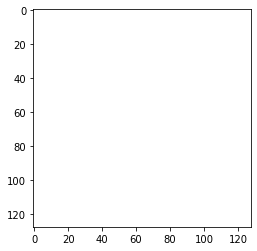

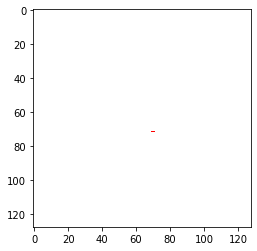

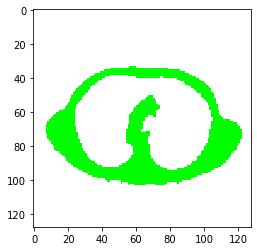

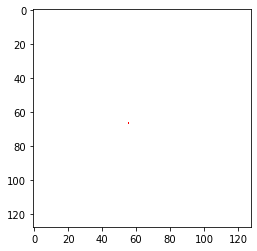

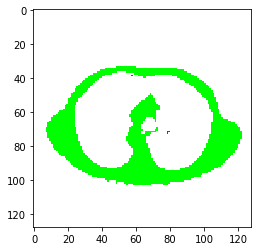

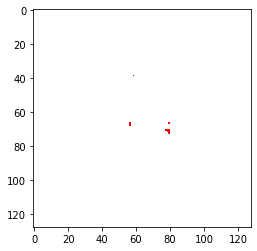

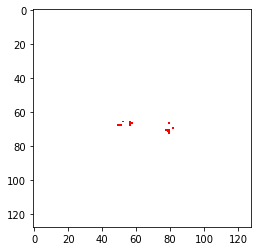

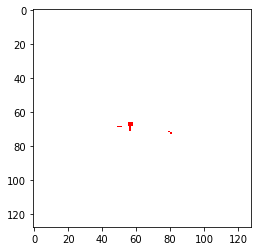

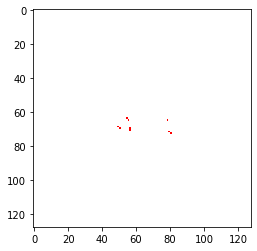

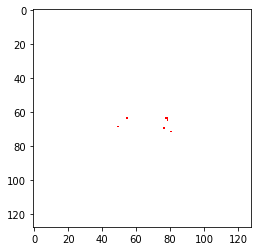

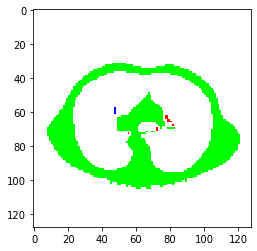

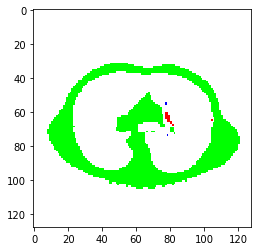

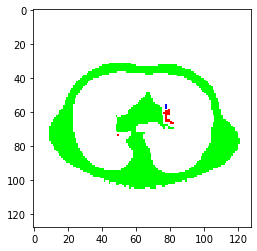

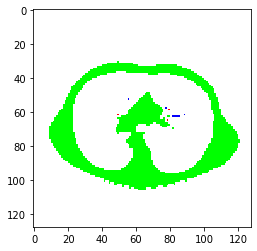

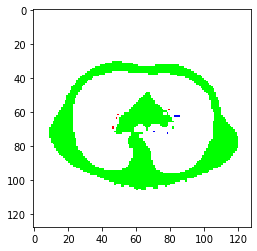

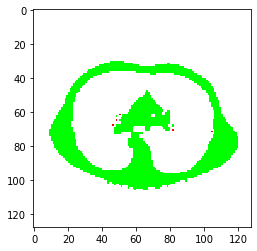

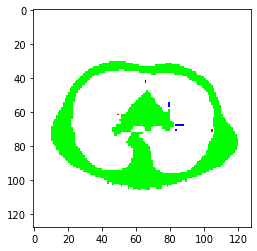

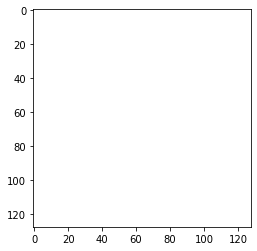

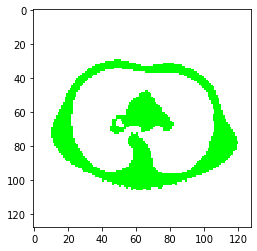

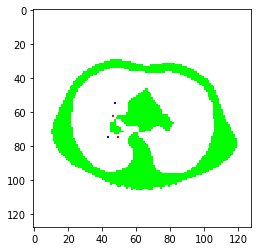

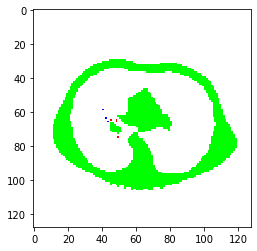

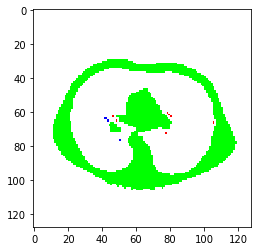

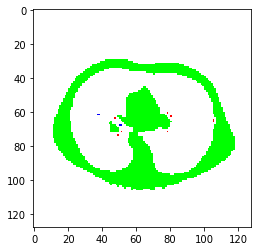

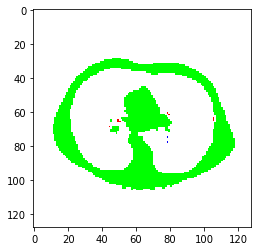

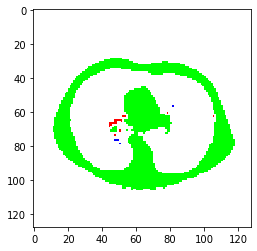

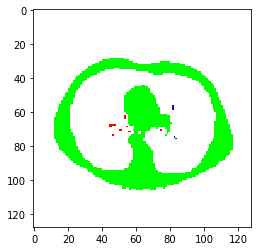

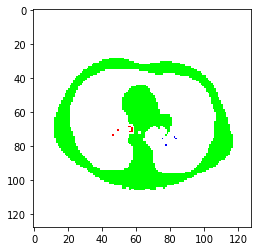

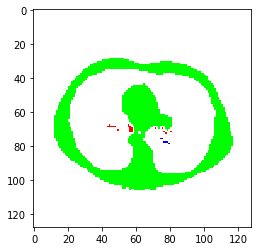

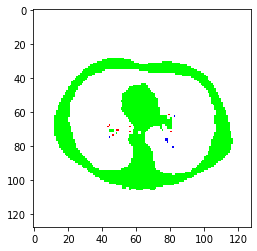

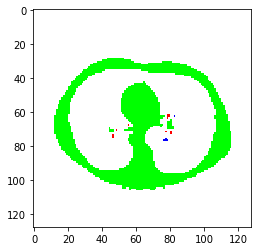

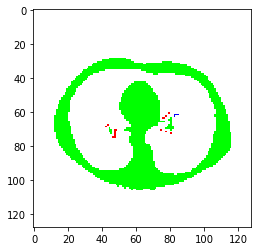

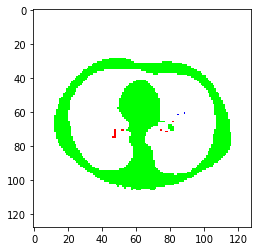

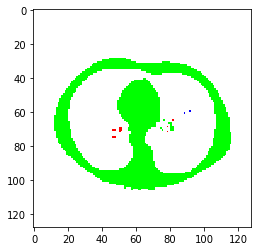

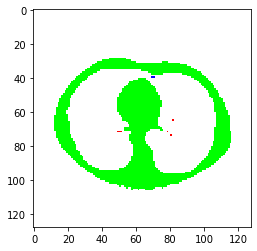

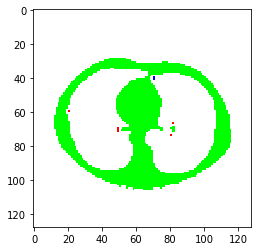

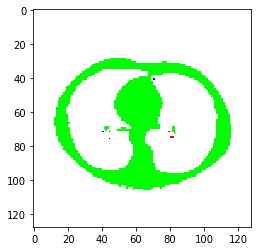

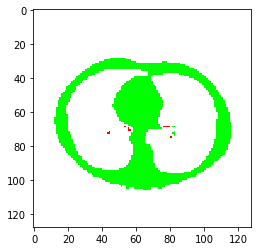

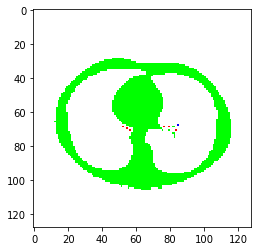

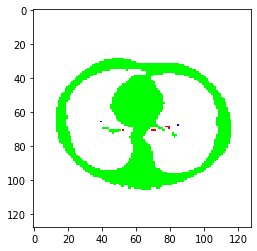

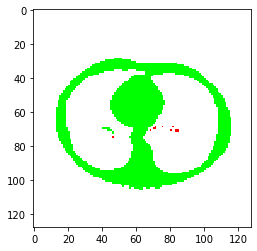

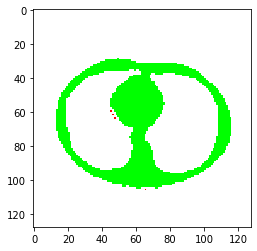

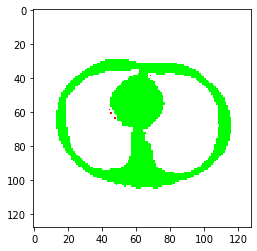

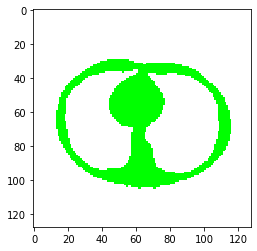

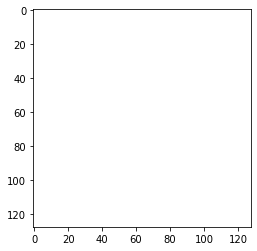

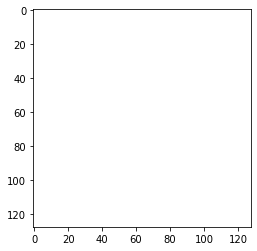

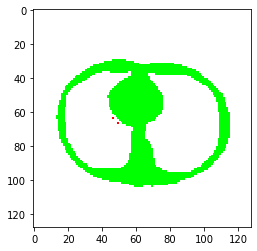

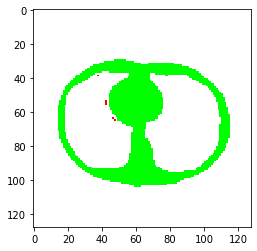

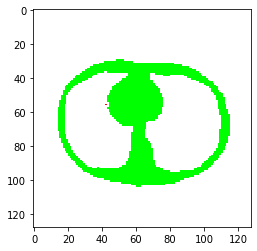

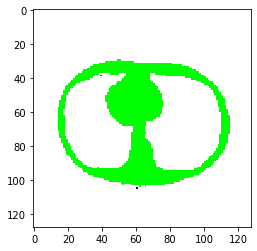

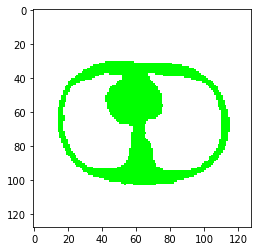

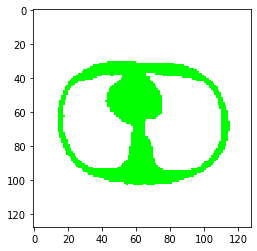

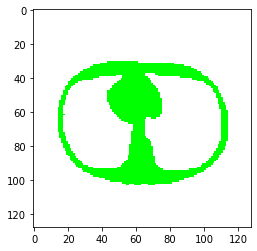

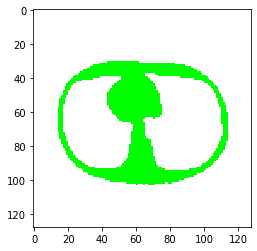

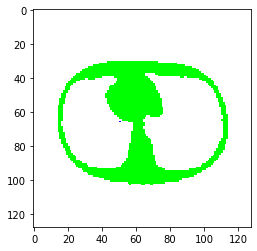

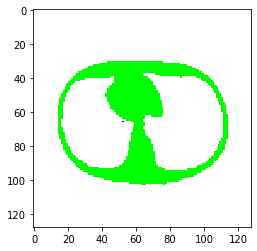

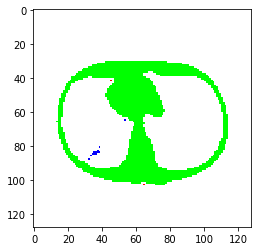

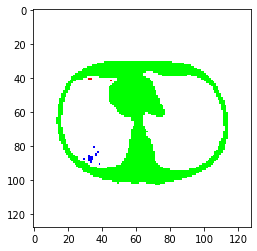

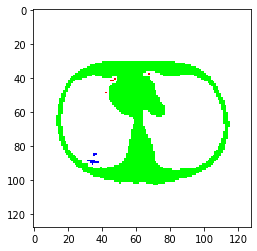

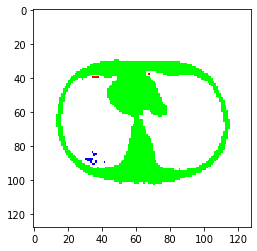

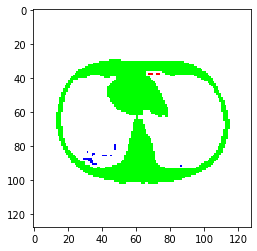

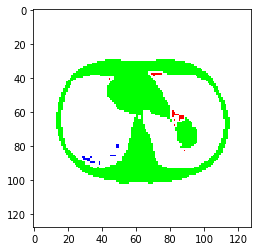

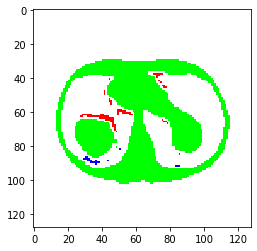

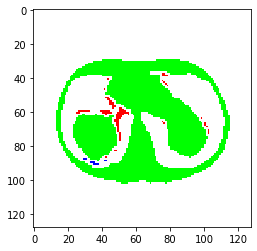

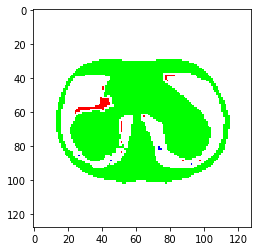

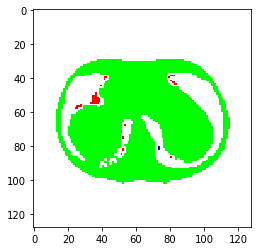

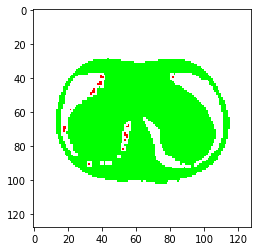

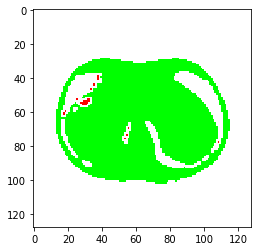

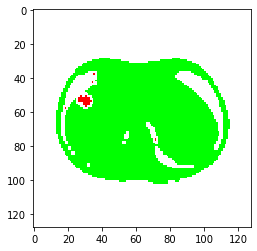

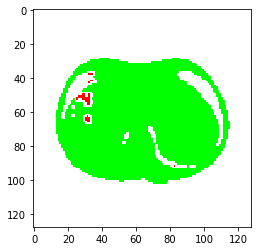

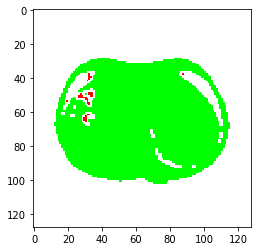

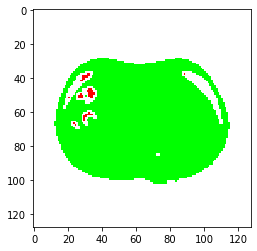

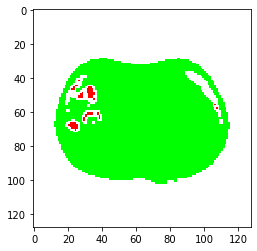

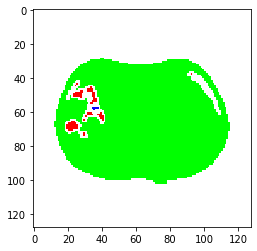

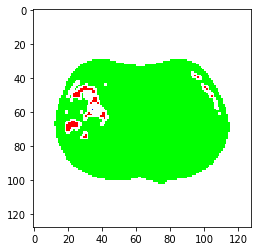

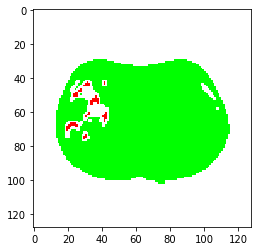

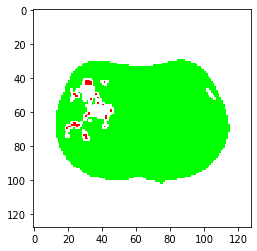

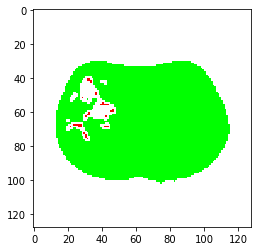

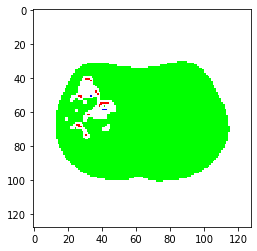

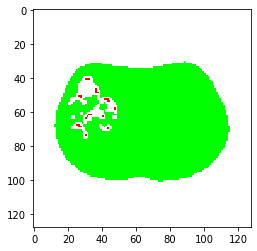

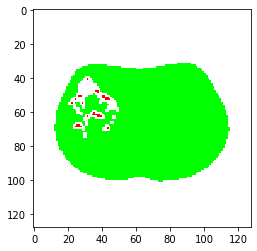

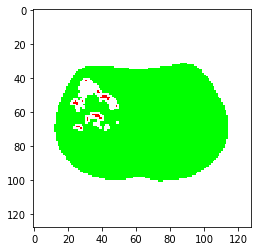

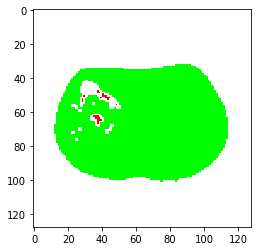

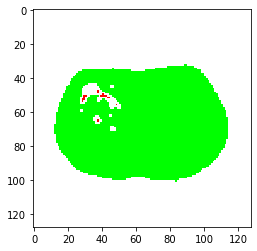

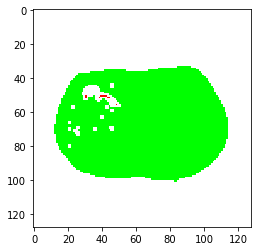

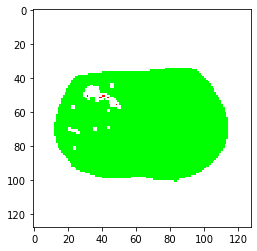

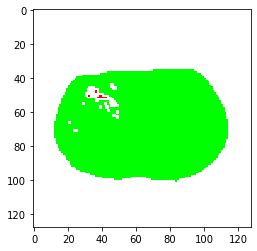

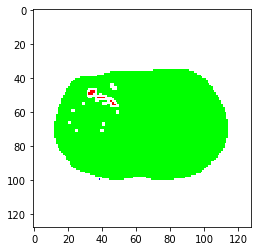

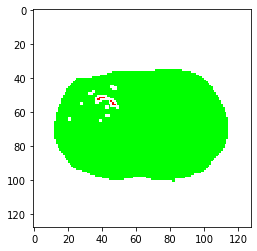

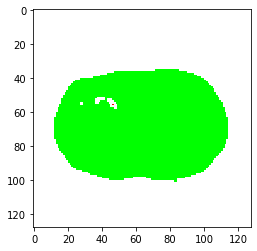

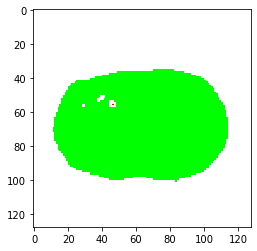

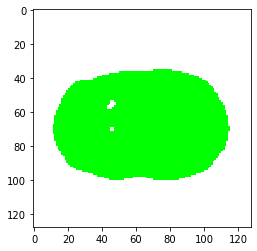

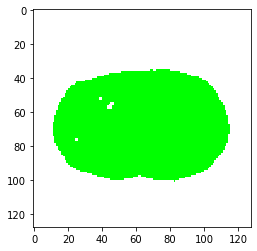

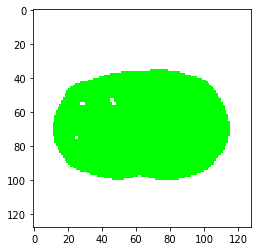

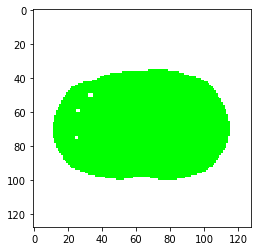

In [50]:
for i in range(0, 128):
    
    plt.imshow(tp[i], cmap = 'brg', vmin = 0.1)
    plt.imshow(fp[i], cmap = 'brg', vmin = 0.1, vmax = 100)
    plt.imshow(fn[i], cmap = 'brg', vmin = 0.1, vmax = 90)
    plt.show(block = True)

In [19]:
def dice_score(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

print(dice_score(extract_lung_mask(true_array), extract_lung_mask(false_array)))

0.9269309799761248


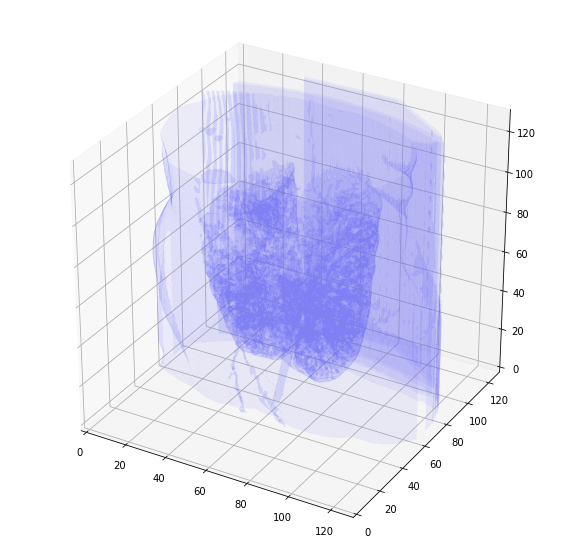

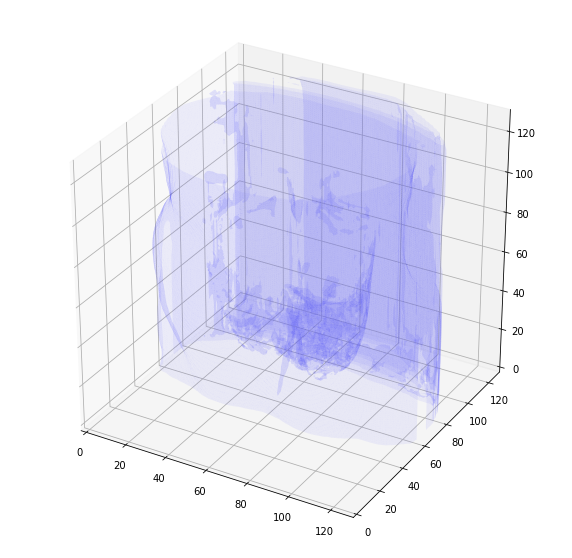

In [13]:


def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(true_array, 0.1)
plot_3d(false_array, 0.1)